# 2018 11 06 Getting over the optimization of filters
Fonction OK, il reste maintenant à faire le temps correct pour prendre en compte les FPS de la vidéo

Il y a aussi le souci de rajouter des spikes sur le plot du voltage membranaire

TODO : Faire marcher le filtre pour n'importe quelle taille d'input ou fournir un input carré de 64x64

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from LogGabor import LogGabor

In [25]:
# les classiques


def spatial_filter(wx=5., wy=5., xres=.1, yres=.1, sigma_center=1., sigma_surround=1.2,
                   x_trans=0, y_trans=0, theta=0, end_multiplier=-1.):
    ''' wx, wy : x/y width
    xres, yres : x/y resolution
    sigma_center : U.A related to the center of the circle
    sigma_surround : U.A related to the surround of of the circle
    x_trans, y_trans : 0, 0 #translation of the filter
    end_mutiplier : decreases the spatial filter response and triggers ON(negative value) or OFF(positives)
    center-surround fields
    '''
    x = np.arange((-wx+x_trans), (wx+x_trans), xres)
    y = np.arange((-wy+y_trans), (wy+y_trans), yres)
    X, Y = np.meshgrid(x, y)

    radius = np.sqrt((X-x_trans)**2 + (Y-y_trans)**2)
    center = (1.0 / sigma_center**2) * np.exp(-.5*(radius / sigma_center)**2)
    surround = (1.0 / sigma_surround**2) * \
        np.exp(-.5*(radius / sigma_surround)**2)

    Z = surround - center
    Z *= end_multiplier
    return X, Y, Z


def temporal_filter(t=1, response_time=175, refrac_time=50,
                    K1=.92, c1=0.2, n1=7, t1=-6,
                    K2=.2, c2=.12, n2=8, t2=-6,
                    baseline=0., gain=90):
    '''
    Arguments :
    --> time = time for which the filter's reponse is calculated
    --> total_time = time the filter takes to do a full response, starting from 0, peaking, undershooting
    and going to 0 again
    --> refrac_time = refraction time after which the filter can be activated again
    --> other params are as f(x) = K * [ (c*(t-1))**2 * e^(-c1(t-t1)) ] / [ (n**2) * e^-n]
    (see wikipedia for formula)
    -->-->K relates to the height, c to the opening
    '''

    #t = np.arange(0, total_time*t_res, t_res)
    p = baseline
    p += K1 * ((c1 * (t - t1))**n1 * np.exp(-c1 * (t-t1))) / \
        (n1**2)*np.exp(-n1)
    p -= K2 * ((c2 * (t - t2))**n2 * np.exp(-c2 * (t-t2))) / \
        (n2**2)*np.exp(-n2)
    return p*gain  # oups je me suis planté d'un facteur 90, c'est un sacré miss

In [26]:
def gabor_connectivity(filters, phi, theta, threshold, on=True):
    '''
    From an array of filters and a gabor phi-space, returns the filters in the phi-space above a threshold
    Args :
        Filters (ndarray) : A 2D array of filters to localize on the gabor
        Phi : A phi space from a LogGabor
        Threshold : the threshold above which (or below, given 'on' param) we select the filters
        on : True if we're passing on center filters, False if we're doing off center filters
    '''
    if on:
        gab_above_threshold = np.array(
            [*np.where(phi[theta, 0] > threshold)], dtype=float).T
    else:
        gab_above_threshold = np.array(
            [*np.where(phi[theta, 0] < threshold)], dtype=float).T

    filters_in_gabor = []
    for it, filt in enumerate(filters):
        for gabs in gab_above_threshold:
            if np.all(filt.astype(int) == gabs):
                filters_in_gabor.append(filt)

    return filters_in_gabor

In [27]:
def save_currents(savepath, arr_nbr, arr):
    '''
    Uses numpy basic array saving to dump all the currents into a subfolder of the output folder 
    '''
    
    import os
    if not os.path.exists(savepath):
        os.makedirs(savepath)
        
    np.save(savepath+str(arr_nbr)+'.npy', np.asarray(arr))

In [28]:
def generate_small_gabors_coordinates_multithread(theta,params, N_X, N_Y,  centers_coordinates, nbr_gabors=6,
                                      B_theta=15, sf_0=.05, B_sf=.5,
                                      distrib_size=8, grid_res=3, on_thresh=.1, off_thresh=-.1,
                                      verbose=True):
    '''
    Multithreading modification : we pass the theta as an argument
    
    Given some gabor parameters, a set of coordinates for centering gabors, returns a set of 
    coordinates for filters belonging into the gabors

    The code iterates through thetas and generate nbr_gabors set of ON/OFF filters

    Params :
        params : the default parameters dictionnary
        N_X, N_Y : Gabor size, usually the same as the video, 54 usually
        N_theta : number of orientations
        centers_coordinates : a 2D array containing two list of coordinates for
                                centering the gabors
        nbr_gabors : the number of gabor done per each theta
        B_theta, sf_0, B_sf : usual params for the gabor shape, 
                                B_theta being the opening of the gabor, sf_0 the spatia frequency 
                                and b_sf the bandwidth frequency
    '''

    xs = centers_coordinates[0]
    ys = centers_coordinates[1]

    N_X = int(N_X)
    N_Y = int(N_Y)
    N_phase = 2

    lg = LogGabor(params)
    lg.set_size((N_X, N_Y))

    B_theta = B_theta / 180 * np.pi
    params = {'sf_0': sf_0, 'B_sf': B_sf, 'B_theta': B_theta}

    filters_per_theta = []

    phi = np.zeros((1, N_phase, N_X, N_Y))
    params.update(theta=theta)

    filters_per_gab = []
    for gab in range(nbr_gabors):
        x = xs[gab]
        y = ys[gab]

        for i_phase in range(N_phase):
            phase = i_phase * np.pi/2
            kernel = lg.invert(lg.loggabor(
                x, y, **params)*np.exp(-1j*phase))
            phi[0, i_phase, :] = lg.normalize(kernel)

        fx_min = x - distrib_size
        fx_max = x + distrib_size
        fy_min = y - distrib_size
        fy_max = y + distrib_size
        filters_coordinates = np.mgrid[fx_min:fx_max:grid_res,
                                       fy_min:fy_max:grid_res].reshape(2, -1).T
        if verbose and gab == 0:
            print('Thread started !\nFilter grid shape', filters_coordinates.shape, '\n')

        filters_in_gabor = gabor_connectivity(filters=filters_coordinates,
                                              phi=phi, theta=0, threshold=on_thresh)
        off_filters_in_gabor = gabor_connectivity(filters=filters_coordinates,
                                                  phi=phi, theta=0, threshold=off_thresh, on=False)

        filters_per_gab.append((filters_in_gabor, off_filters_in_gabor))

    

    return filters_per_gab

In [6]:
from joblib import Parallel, delayed

gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                        'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                        'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                        'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                        'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                        'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                        'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                        'white_recompute': False, 'white_steepness': 4.0}

distrib_size = 8
grid_res = 3
N_theta = 12
centers_coordinates = np.array(
    [[35, 20, 35, 10, 20, 35], [35, 20, 10, 35, 35, 20]])

filters_multithread = Parallel(n_jobs=-1, backend='loky', verbose = 10)(delayed(generate_small_gabors_coordinates_multithread)
                    (theta,
                     params=gabors_parameterfile, N_X=54, N_Y=54,
                     centers_coordinates=centers_coordinates,
                     distrib_size=distrib_size, grid_res=grid_res)
                        for theta in np.linspace(0, np.pi, N_theta))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   24.4s remaining:   17.5s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   30.8s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   34.0s finished


In [7]:
np.asarray(filters_multithread).shape

(12, 6, 2)

In [8]:
def coordinates_to_currents_multithread(filters,
                            stimuli, total_time, filter_size, filter_res):
    '''
    Unused atm, implements a lower sampling rate to do faster currents
    Multithreading modification : filters are passed together then separeted in the function,
    to ease the iterators on the Joblib Delayed decorator
    
    Creates currents from spatiotemporal filters in given coordinates set, by convolving
    the apex of the ST filter with the receptive field in a fed video

    Args :
        filters_in_gabor : a set of coordinates for ON CENTER RFs
        off_filters_in_gabor : a set of coordinates for OFF CENTER RFs

        stimulus = a video transformed into a numpy array (see the associated .py file)
                    must be (WxHxlen) shape
        total_time = total time of the current simulation, usually equal to the stimulus length

        filter_size, filter_res = spatiotemporal filters arguments
                                    other parameters have been optimized and are left by default

    '''
    
    sampling_rate = 250 #number of linspace point, eg : 250 for 1000 total_time = 200Hz
    
    levels_per_gabor = []
    for gabors in filters : #iterate through the six gabor per filter
        
        filters_in_gabor, off_filters_in_gabor = gabors[0], gabors[1] #simple as that
        # a number of aborted filters due to edge-closeness
        err_nbr = 0

        # LES FILTRES ON

        st_list = []
        on_st_levels = []

        for filt in range(len(filters_in_gabor)):
            try:
                X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                         xres=filter_res, yres=filter_res,
                                         x_trans=filters_in_gabor[filt][0],
                                         y_trans=filters_in_gabor[filt][1])
                t = [temporal_filter(i)
                     for i in np.linspace(0, total_time, sampling_rate)]
            
                # Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)
                
                activations = []
                for i in np.linspace(0, total_time-1, sampling_rate):
                    activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                              * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]


                st_list.append(st)

                on_st_level = []
                for i in range(sampling_rate):
                    on_st_level.append(np.max(st[:, :, i]))
                on_st_levels.append(on_st_level)
            except:
                err_nbr += 1
                pass

        # LES FILTRES OFF
        st_list = []
        off_st_levels = []

        for filt in range(len(off_filters_in_gabor)):
            try:
                X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                         xres=filter_res, yres=filter_res,
                                         x_trans=off_filters_in_gabor[filt][0],
                                         y_trans=off_filters_in_gabor[filt][1],
                                         end_multiplier=1.)
                t = [temporal_filter(i)
                     for i in np.linspace(0, total_time, sampling_rate)]

                # Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, sampling_rate):
                    activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                              * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]


                st_list.append(st)

                off_st_level = []
                for i in range(sampling_rate):
                    off_st_level.append(np.max(st[:, :, i]))
                off_st_levels.append(off_st_level)
            except:
                err_nbr += 1
                pass

        if err_nbr > 0:
            print('Due to misplacement, %s / %s filters were removed' %
                  (err_nbr, (len(filters_in_gabor)+len(off_filters_in_gabor))))
        levels_per_gabor.append((on_st_levels, off_st_levels))

    return levels_per_gabor

In [9]:
def coordinates_to_currents_multithread(filters,
                            stimuli, total_time, filter_size, filter_res):
    '''
    Multithreading modification : filters are passed together then separeted in the function,
    to ease the iterators on the Joblib Delayed decorator
    
    Creates currents from spatiotemporal filters in given coordinates set, by convolving
    the apex of the ST filter with the receptive field in a fed video

    Args :
        filters_in_gabor : a set of coordinates for ON CENTER RFs
        off_filters_in_gabor : a set of coordinates for OFF CENTER RFs

        stimulus = a video transformed into a numpy array (see the associated .py file)
                    must be (WxHxlen) shape
        total_time = total time of the current simulation, usually equal to the stimulus length

        filter_size, filter_res = spatiotemporal filters arguments
                                    other parameters have been optimized and are left by default

    '''
    levels_per_gabor = []
    for gabors in filters : #iterate through the six gabor per filter
        
        filters_in_gabor, off_filters_in_gabor = gabors[0], gabors[1] #simple as that
        # a number of aborted filters due to edge-closeness
        err_nbr = 0

        # LES FILTRES ON

        st_list = []
        on_st_levels = []

        for filt in range(len(filters_in_gabor)):
            try:
                X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                         xres=filter_res, yres=filter_res,
                                         x_trans=filters_in_gabor[filt][0],
                                         y_trans=filters_in_gabor[filt][1])
                t = [temporal_filter(i)
                     for i in np.linspace(0, total_time, total_time)]

                # Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, total_time):
                    activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                              * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]


                st_list.append(st)

                on_st_level = []
                for i in range(total_time):
                    on_st_level.append(np.max(st[:, :, i]))
                on_st_levels.append(on_st_level)
            except:
                err_nbr += 1
                pass

        # LES FILTRES OFF
        st_list = []
        off_st_levels = []

        for filt in range(len(off_filters_in_gabor)):
            try:
                X, Y, Z = spatial_filter(wx=filter_size, wy=filter_size,
                                         xres=filter_res, yres=filter_res,
                                         x_trans=off_filters_in_gabor[filt][0],
                                         y_trans=off_filters_in_gabor[filt][1],
                                         end_multiplier=1.)
                t = [temporal_filter(i)
                     for i in np.linspace(0, total_time, total_time)]

                # Convolution coordinates, centered around the filter and the size of the filter space
                X_convo_minus = int(off_filters_in_gabor[filt][0]-filter_size)
                X_convo_plus = int(off_filters_in_gabor[filt][0]+filter_size)
                Y_convo_minus = int(off_filters_in_gabor[filt][1]-filter_size)
                Y_convo_plus = int(off_filters_in_gabor[filt][1]+filter_size)

                activations = []
                for i in np.linspace(0, total_time-1, total_time):
                    activations.append(np.max(stimuli[:, :, int(i)][X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]
                                              * Z[X_convo_minus:X_convo_plus, Y_convo_minus:Y_convo_plus]))

                ys = np.convolve(t, activations)
                st = Z[:, :, None] * ys[None, None, :]

                st_list.append(st)

                off_st_level = []
                for i in range(total_time):
                    off_st_level.append(np.max(st[:, :, i]))
                off_st_levels.append(off_st_level)
            except:
                err_nbr += 1
                pass

        if err_nbr > 0:
            print('Due to misplacement, %s / %s filters were removed' %
                  (err_nbr, (len(filters_in_gabor)+len(off_filters_in_gabor))))
        levels_per_gabor.append((on_st_levels, off_st_levels))

    return levels_per_gabor

In [10]:
from joblib import Parallel, delayed

gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                        'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                        'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                        'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                        'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                        'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                        'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                        'white_recompute': False, 'white_steepness': 4.0}

total_time = 1000
filter_size = 2.
filter_res = .1

video = np.load('../montypython.npy')
video = np.rot90(video)


#with theta-based loop : 

currents_multithread = Parallel(n_jobs=-1, backend='loky')(delayed(coordinates_to_currents_multithread)
                              (filters,
                               stimuli=video, total_time=total_time,
                               filter_size=filter_size, filter_res=filter_res)
                                for filters in filters_multithread)


In [11]:
np.asarray(currents_multithread).shape

(12, 6, 2)

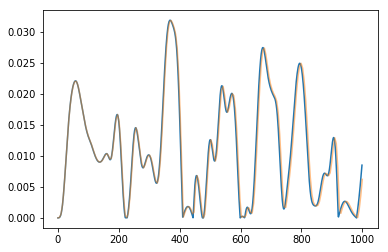

In [12]:
plt.plot(currents_multithread[1][0][0][0])#current for second theta, first gabor, on filters, first on filter

#théorème de shannon, on a pas besoin d'échantillonner plus que 2 fois la fréquence du plus petit evenement
#1 AP = 1 ms, donc on peut descendre à 120Hz si besoin. On prend 200 pour etre large ?
plt.plot(np.linspace(0,1000,200),currents_multithread[1][0][0][0][::5], alpha = .5)

In [13]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

#neuron_params = sim.IF_cond_alpha.default_parameters

st_levels = currents_multithread[0][0] #we inject only the first theta, first gabor
gain = 2
injection_sampling_rate = 1
current_times = np.linspace(0,total_time,len(st_levels[0][0][::injection_sampling_rate]))
current_list = []

##############
# Simulation #
##############
sim.setup(timestep=0.1)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


#injecting all ON cells current
for inputs in range(len(st_levels[0])):

    current_levels = st_levels[0][inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)

    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels*gain)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()
    
#injecting all OFF cells current
for inputs in range(len(st_levels[1])):

    current_levels = st_levels[1][inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)

    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels*gain)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()
    
post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v = post.get_data().segments[0]
sig = post_v.analogsignals[0]

/home/hugo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


# The non-showing spikes problem 

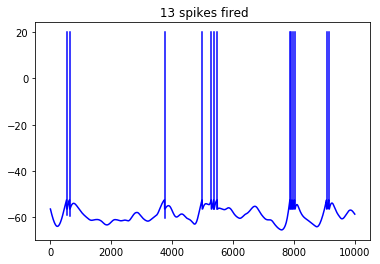

In [14]:
plt.plot(sig, color = 'b')

for spikes in np.asarray(post_v.spiketrains[0]):
    plt.plot( [ spikes*10,spikes*10 ] , [sig[int(spikes)] , 20], color = 'b')
    #plt.axvline(spikes*10, ymin = .15, ymax = .9)
    
plt.title(' %s spikes fired' % np.asarray(post_v.spiketrains[0]).shape[0])
plt.show()

(-1, 1001)

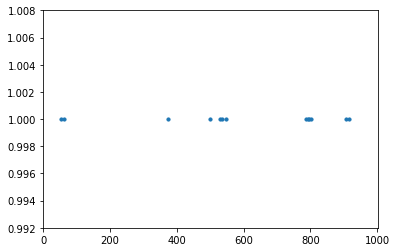

In [15]:
plt.scatter(post_v.spiketrains, np.ones_like(post_v.spiketrains), s = 10)
plt.xlim(-1, 1001)

# The FPS problem

In [16]:
brian_vid = np.load('./LifeOfBrian_29.97FPS.npy')
brian_vid = np.swapaxes(brian_vid, 0, -1)
brian_vid = np.swapaxes(brian_vid, 0, 1)
brian_vid.shape

(36, 64, 640)

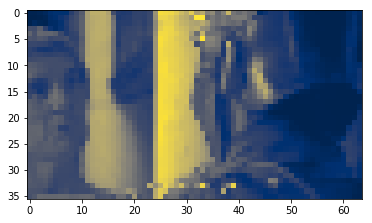

In [17]:
plt.imshow(brian_vid[:,:,4], cmap = plt.cm.cividis)

In [18]:
print('Total frames:', brian_vid.shape[-1])

#médaille d'or du one liner 2018
fps = float('./LifeOfBrian_29.97FPS.npy'.split('_')[1].split('FPS')[0])
print('Frames per second:', fps)
print('Frame duration at %s fps: %.2f ms' % (fps, total_time/fps))
print('Video length inferred from fps: %s s'% brian_vid[:,:,::int(fps)].shape[-1])
frame_duration = int(total_time/fps)

stimuli = []
for ms in range(int(total_time/frame_duration)) :
    for same_frame in range(frame_duration):
        stimuli.append(brian_vid[:,:,ms])
while len(stimuli) < total_time:
    stimuli.append(stimuli[-1])
        
#Check that a random pixel is the same in the previous frame
if stimuli[0][0,30]!=stimuli[frame_duration+1][0,30] : print('Sanity check passed !')


Total frames: 640
Frames per second: 29.97
Frame duration at 29.97 fps: 33.37 ms
Video length inferred from fps: 23 s
Sanity check passed !


In [19]:
stimuli =  np.swapaxes(stimuli, 0, -1)
stimuli = np.swapaxes(stimuli, 0, 1)
stimuli.shape

(36, 64, 1000)

In [20]:
#generate the coordinates
from joblib import Parallel, delayed

gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                        'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                        'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                        'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                        'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                        'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                        'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                        'white_recompute': False, 'white_steepness': 4.0}

distrib_size = 8
grid_res = 3
N_theta = 12
centers_coordinates = np.array(
    [[35, 20, 35, 10, 20, 35], [35, 20, 10, 35, 35, 20]])

filters_multithread = Parallel(n_jobs=-1, backend='loky', verbose = 10)(delayed(generate_small_gabors_coordinates_multithread)
                    (theta,
                     params=gabors_parameterfile, N_X=stimuli.shape[1], N_Y=stimuli.shape[0],
                     centers_coordinates=centers_coordinates,
                     distrib_size=distrib_size, grid_res=grid_res)
                        for theta in np.linspace(0, np.pi, N_theta))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   20.7s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   27.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   30.3s finished


In [21]:
#generate the currents
from joblib import Parallel, delayed

gabors_parameterfile = {'B_sf': 0.4, 'B_theta': 0.17453277777777776, 'N_X': 256, 'N_Y': 256,
                        'N_image': 100, 'base_levels': 1.618, 'datapath': 'database', 'do_mask': True,
                        'do_whitening': True, 'dpi': 450, 'edgefigpath': 'results/edges', 'edgematpath': 'cache_dir/edges',
                        'ext': '.pdf', 'figpath': 'results', 'figsize': 14.0, 'formats': ['pdf', 'png', 'jpg'],
                        'mask_exponent': 3.0, 'matpath': 'cache_dir', 'n_theta': 24, 'noise': 0.1, 'seed': None,
                        'use_cache': True, 'verbose': 0, 'white_N': 0.07, 'white_N_0': 0.0, 'white_alpha': 1.4,
                        'white_f_0': 0.4, 'white_n_learning': 0, 'white_name_database': 'kodakdb',
                        'white_recompute': False, 'white_steepness': 4.0}

total_time = 1000
filter_size = 2.
filter_res = .1

video = np.load('../montypython.npy')
video = np.rot90(video)

#this generates all the currents for ONE theta only, 15 s per theta, so I infer 180s runtime
#with theta-based loop : 

currents_multithread = Parallel(n_jobs=-1, backend='loky')(delayed(coordinates_to_currents_multithread)
                              (filters,
                               stimuli=stimuli, total_time=total_time,
                               filter_size=filter_size, filter_res=filter_res)
                                for filters in filters_multithread)


In [22]:
import pyNN.nest as sim
from pyNN.random import RandomDistribution as rnd
from pyNN.parameters import Sequence
from pyNN.utility.plotting import Figure, Panel

##########
# Params #
##########
neuron_params = {'cm': .5, #nF - McCormick
                 'e_rev_E': 0.0, #mV - McCormick but default values
                 'e_rev_I': -70.0, #mV - McCormick but default values
                 'tau_m': 30, #ms - Markram
                 'tau_refrac': 1.5, #ms - McCormick
                 'tau_syn_E': 0.25, #ms -McCormick
                 'tau_syn_I': 0.75, #ms - McCormick
                 'v_reset': -56.5, #mV - McCormick
                 'v_rest': -73.6, #mV - McCormick
                 'v_thresh': -52.5 #mV - McCormick #mV - McCormick
                    }

#neuron_params = sim.IF_cond_alpha.default_parameters

st_levels = currents_multithread[0][0] #we inject only the first theta, first gabor
gain = .5
injection_sampling_rate = 1
current_times = np.linspace(0,total_time,len(st_levels[0][0][::injection_sampling_rate]))
current_list = []

##############
# Simulation #
##############
sim.setup(timestep=0.1)

post = sim.Population(1, sim.IF_cond_alpha(**neuron_params),
                    initial_values={"v": neuron_params["v_reset"]}, label="postsynaptic")


#injecting all ON cells current
for inputs in range(len(st_levels[0])):

    current_levels = st_levels[0][inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)

    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels*gain)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()
    
#injecting all OFF cells current
for inputs in range(len(st_levels[1])):

    current_levels = st_levels[1][inputs][::injection_sampling_rate]
    current_levels = np.asarray(current_levels)

    current_input = sim.StepCurrentSource(times = current_times,
                                     amplitudes = current_levels*gain)
    current_input.inject_into(post)
    current_list.append(current_input)
    current_input.record()
    
post.record(['spikes', 'v'])

sim.run(total_time)
sim.end()

#PLOTTING and DATA
post_v = post.get_data().segments[0]
sig = post_v.analogsignals[0]

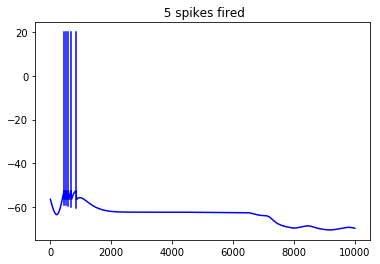

In [23]:
plt.plot(sig, color = 'b')

for spikes in np.asarray(post_v.spiketrains[0]):
    plt.plot( [ spikes*10,spikes*10 ] , [sig[int(spikes)] , 20], color = 'b')
    #plt.axvline(spikes*10, ymin = .15, ymax = .9)
    
plt.title(' %s spikes fired' % np.asarray(post_v.spiketrains[0]).shape[0])
plt.show()

import datetime
now = datetime.datetime.now()
strtime = now.strftime("%Y-%m-%d_%H_%M")

save_currents('./output/'+strtime+'/', 0, currents_multithread)